## This Notebook contains code to clean the data

### The following have been done as part of data cleaning:
#### 1. Replaced all the "?" and string "NULL" values with null/missing values in order to handle such missing values
#### 2. Dropped columns such as 'weight', 'payer code' & 'medical speciality' as they contain a large number of missing values
#### 3. Replaced missing values in 'diag1', 'diag2', 'diag3' & 'Race' columns with the MODE (most frequently occuring value) value of that column
#### 4. Dropped Primary Key/Foreign Key columns such as 'encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id' & 'admission_source_id' as they are not useful for our analysis
#### 5. Dropped columns such as 'acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone' & 'metformin-pioglitazone' as these 10 columns have almost 0 variance with every row of these columns having the exact same value. Such columns with very low variance are not useful in explaining our dependent variable and hence they need to be dropped
#### 6. Plotted the histogram of numeric variables to view their distribution and check for outliers. 

#### The final cleaned dataframe contains 101766 rows & 35 columns


In [1]:
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics
from pyspark.ml import feature
from pyspark.ml import clustering
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from math import exp, log10, fabs, atan, log
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.classification import GBTClassifier

In [2]:
# Do not delete or change this cell

# grading import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

### Reading CSV into Spark dataframe
#### CSV contains data of all diabetic patients with their "admission type ids", "discharge disposition ids" and "admission source ids" mapped to their corresponding values

In [3]:
hosp_readmit_id_mapped_df = spark.read.csv(get_training_filename('diabetic_data_id_mapped.csv'), header=True, inferSchema=True)

#### Printing the Head and shape of the DF

In [4]:
print("Shape of hosp_readmit_id_mapped_df is: ",(hosp_readmit_id_mapped_df.count(), len(hosp_readmit_id_mapped_df.columns)))
hosp_readmit_id_mapped_df.toPandas().head()

Shape of hosp_readmit_id_mapped_df is:  (101766, 53)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,admission_type_name,discharge_disposition_id,dischage_disposition_name,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,NULL,25,Not Mapped,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,Emergency,1,Discharged to home,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,Emergency,1,Discharged to home,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,Emergency,1,Discharged to home,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,Emergency,1,Discharged to home,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


##### We can observe a lot of special character "?" values in the dataset, 
#### Replacing special character '?' with Null

In [5]:
hosp_readmit_id_mapped_df = hosp_readmit_id_mapped_df.select([fn.when(fn.col(c) == '?',None).otherwise(fn.col(c)).alias(c) for c in hosp_readmit_id_mapped_df.columns])

###### Printing Head and Shape of DF after replacing "?" with NULL

In [6]:
print("Shape of hosp_readmit_id_mapped_df after replacing ? is: ",(hosp_readmit_id_mapped_df.count(), len(hosp_readmit_id_mapped_df.columns)))
hosp_readmit_id_mapped_df.toPandas().head()

Shape of hosp_readmit_id_mapped_df after replacing ? is:  (101766, 53)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,admission_type_name,discharge_disposition_id,dischage_disposition_name,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),None,6,NULL,25,Not Mapped,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),None,1,Emergency,1,Discharged to home,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),None,1,Emergency,1,Discharged to home,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),None,1,Emergency,1,Discharged to home,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),None,1,Emergency,1,Discharged to home,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Handling DATA QUALITY ISSUES

### A. Checking number of distinct values in each column to get rid of columns with No Variance, i.e. columns that have a single value across all the rows
###### Such columns with no variance needs to be removed as they will have no role in explaining the target variable

In [7]:
hosp_readmit_id_mapped_df.select([fn.countDistinct(c) for c in hosp_readmit_id_mapped_df.columns]).show()

+----------------------------+---------------------------+--------------------+----------------------+-------------------+----------------------+---------------------------------+-----------------------------------+----------------------------------------+-----------------------------------------+-----------------------------------+-------------------------------------+--------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------+-------------------------------+---------------------------------+--------------------------------+--------------------------------+----------------------+----------------------+----------------------+--------------------------------+-----------------------------+-------------------------+-------------------------+---------------------------+---------------------------+------------------------------+---------------------------+-----------------------------+-------

###### 1. Column "acetohexamide" can be removed because of close to 0 variance, as almost all the values under this column are "No" and only 1 value is "Steady"

In [8]:
hosp_readmit_id_mapped_df.groupBy("acetohexamide").count().show()

+-------------+------+
|acetohexamide| count|
+-------------+------+
|       Steady|     1|
|           No|101765|
+-------------+------+



###### 2. Column "tolbutamide" can be removed because of close to 0 variance

In [9]:
hosp_readmit_id_mapped_df.groupBy("tolbutamide").count().show()

+-----------+------+
|tolbutamide| count|
+-----------+------+
|     Steady|    23|
|         No|101743|
+-----------+------+



###### 3. Column "troglitazone" can be removed because of close to 0 variance

In [10]:
hosp_readmit_id_mapped_df.groupBy("troglitazone").count().show()

+------------+------+
|troglitazone| count|
+------------+------+
|      Steady|     3|
|          No|101763|
+------------+------+



###### 4. Column "tolazamide" can be removed because of close to 0 variance

In [11]:
hosp_readmit_id_mapped_df.groupBy("tolazamide").count().show()

+----------+------+
|tolazamide| count|
+----------+------+
|    Steady|    38|
|        Up|     1|
|        No|101727|
+----------+------+



###### 5. Column "examide" can be removed because of  0 variance

In [12]:
hosp_readmit_id_mapped_df.groupBy("examide").count().show()

+-------+------+
|examide| count|
+-------+------+
|     No|101766|
+-------+------+



###### 6. Column "citoglipton" can be removed because of  0 variance

In [13]:
hosp_readmit_id_mapped_df.groupBy("citoglipton").count().show()

+-----------+------+
|citoglipton| count|
+-----------+------+
|         No|101766|
+-----------+------+



###### 7. Column "glipizide-metformin" can be removed because of close to  0 variance

In [14]:
hosp_readmit_id_mapped_df.groupBy("glipizide-metformin").count().show()

+-------------------+------+
|glipizide-metformin| count|
+-------------------+------+
|             Steady|    13|
|                 No|101753|
+-------------------+------+



###### 8. Column "glimepiride-pioglitazone" can be removed because of close to  0 variance

In [15]:
hosp_readmit_id_mapped_df.groupBy("glimepiride-pioglitazone").count().show()

+------------------------+------+
|glimepiride-pioglitazone| count|
+------------------------+------+
|                  Steady|     1|
|                      No|101765|
+------------------------+------+



###### 9. Column "metformin-rosiglitazone" can be removed because of close to  0 variance

In [16]:
hosp_readmit_id_mapped_df.groupBy("metformin-rosiglitazone").count().show()

+-----------------------+------+
|metformin-rosiglitazone| count|
+-----------------------+------+
|                 Steady|     2|
|                     No|101764|
+-----------------------+------+



###### 10. Column "metformin-pioglitazone" can be removed because of close to  0 variance

In [17]:
hosp_readmit_id_mapped_df.groupBy("metformin-pioglitazone").count().show()

+----------------------+------+
|metformin-pioglitazone| count|
+----------------------+------+
|                Steady|     1|
|                    No|101765|
+----------------------+------+



##### DROPPING the above 10 columns

In [25]:
columns_to_drop = ['acetohexamide','tolbutamide','troglitazone','tolazamide','examide','citoglipton','glipizide-metformin',
                   'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']
hosp_readmit_clean_df = hosp_readmit_id_mapped_df.select([column for column in hosp_readmit_id_mapped_df.columns if column not in columns_to_drop])

##### Viewing the Shape and Head of the DF after dropping these column

In [27]:
print("Shape of hosp_readmit_id_mapped_df after dropping is: ",(hosp_readmit_clean_df.count(), len(hosp_readmit_clean_df.columns)))
hosp_readmit_clean_df.toPandas().head()

Shape of hosp_readmit_id_mapped_df after dropping is:  (101766, 43)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,admission_type_name,discharge_disposition_id,dischage_disposition_name,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),None,6,NULL,25,Not Mapped,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),None,1,Emergency,1,Discharged to home,...,No,No,No,No,No,Up,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),None,1,Emergency,1,Discharged to home,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),None,1,Emergency,1,Discharged to home,...,No,No,No,No,No,Up,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),None,1,Emergency,1,Discharged to home,...,No,No,No,No,No,Steady,No,Ch,Yes,NO


### B. Checking number of Nulls in each of the columns
###### There are 7 columns with NULL/missing values that need to be handled

In [28]:
hosp_readmit_clean_df.select([fn.sum(fn.isnull(fn.col(c)).cast('int')).alias(c) for c in hosp_readmit_clean_df.columns]).show()

+------------+-----------+----+------+---+------+-----------------+-------------------+------------------------+-------------------------+-------------------+---------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+---------+---------+------------+-------------+--------+--------+-------+-------------------+------+-----------+----------+
|encounter_id|patient_nbr|race|gender|age|weight|admission_type_id|admission_type_name|discharge_disposition_id|dischage_disposition_name|admission_source_id|admission_source_name|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|c

#### 1. Dropping Weight, Payer Code, Medical Speciality columns because of a high number of missing values. 
#### 2. Also dropping encounter_id, patient_nbr, admission_type_id, discharge_disposition_id, admission_source_id because of their lack of relevance as they are primary key columns

In [31]:
columns_to_drop = ['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr', 
                   'admission_type_id', 'discharge_disposition_id','admission_source_id']
hosp_readmit_clean_df = hosp_readmit_clean_df.select([column for column in hosp_readmit_clean_df.columns if column not in columns_to_drop])

###### Printing Head and Shape after dropping more columns

In [32]:
print("Shape of hosp_readmit_id_mapped_df after dropping more columns is: ",(hosp_readmit_clean_df.count(), len(hosp_readmit_clean_df.columns)))
hosp_readmit_clean_df.toPandas().head()

Shape of hosp_readmit_id_mapped_df after dropping more columns is:  (101766, 35)


,race,gender,age,admission_type_name,dischage_disposition_name,admission_source_name,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NULL,Not Mapped,Physician Referral,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),Emergency,Discharged to home,Emergency Room,3,59,0,18,...,No,No,No,No,No,Up,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),Emergency,Discharged to home,Emergency Room,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),Emergency,Discharged to home,Emergency Room,2,44,1,16,...,No,No,No,No,No,Up,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),Emergency,Discharged to home,Emergency Room,1,51,0,8,...,No,No,No,No,No,Steady,No,Ch,Yes,NO


#### REPLACING string NULLs with Null value

In [37]:
hosp_readmit_clean_df = hosp_readmit_clean_df.select([fn.when(fn.col(c) == 'NULL',None).otherwise(fn.col(c)).alias(c) for c in hosp_readmit_clean_df.columns])

#### Number of NULLs in each of the 7 columns which needs to be handled

In [49]:
na_cols = ['race','diag_1','diag_2','diag_3','admission_type_name','dischage_disposition_name','admission_source_name']
hosp_readmit_clean_df.select([fn.sum(fn.isnull(fn.col(c)).cast('int')).alias(c) for c in na_cols]).show()

+----+------+------+------+-------------------+-------------------------+---------------------+
|race|diag_1|diag_2|diag_3|admission_type_name|dischage_disposition_name|admission_source_name|
+----+------+------+------+-------------------+-------------------------+---------------------+
|2273|    21|   358|  1423|               5291|                     3691|                 6781|
+----+------+------+------+-------------------+-------------------------+---------------------+



##### 3. Handling NULL values of remaining columns having a few NAs

#### Replace NULLs with mode values

##### Creating variables with mode of each column

In [67]:
race_mode = hosp_readmit_clean_df.groupby('race').count().orderBy("count", ascending=False).first()[0]
print(race_mode)
diag1_mode = hosp_readmit_clean_df.groupby('diag_1').count().orderBy("count", ascending=False).first()[0]
print(diag1_mode)
diag2_mode = hosp_readmit_clean_df.groupby('diag_2').count().orderBy("count", ascending=False).first()[0]
print(diag2_mode)
diag3_mode = hosp_readmit_clean_df.groupby('diag_2').count().orderBy("count", ascending=False).first()[0]
print(diag3_mode)
admission_type_mode = hosp_readmit_clean_df.groupby('admission_type_name').count().orderBy("count", ascending=False).first()[0]
print(admission_type_mode)
dischage_disposition_mode = hosp_readmit_clean_df.groupby('dischage_disposition_name').count().orderBy("count", ascending=False).first()[0]
print(dischage_disposition_mode)
admission_source_mode = hosp_readmit_clean_df.groupby('admission_source_name').count().orderBy("count", ascending=False).first()[0].strip()
print(admission_source_mode)

Caucasian
428
276
276
Emergency
Discharged to home
Emergency Room


###### Creating final dataframe with all the columns

In [76]:
hosp_readmit_cleaned_df = hosp_readmit_clean_df.select(
fn.when(fn.isnull(fn.col('race')),race_mode).otherwise(fn.col('race')).alias('race'),
fn.when(fn.isnull(fn.col('diag_1')),diag1_mode).otherwise(fn.col('diag_1')).alias('diag_1'),
fn.when(fn.isnull(fn.col('diag_2')),diag2_mode).otherwise(fn.col('diag_2')).alias('diag_2'),
fn.when(fn.isnull(fn.col('diag_3')),diag3_mode).otherwise(fn.col('diag_3')).alias('diag_3'),
fn.when(fn.isnull(fn.col('admission_type_name')),admission_type_mode).otherwise(fn.col('admission_type_name')).alias('admission_type_name'),
fn.when(fn.isnull(fn.col('dischage_disposition_name')),dischage_disposition_mode).otherwise(fn.col('dischage_disposition_name')).alias('dischage_disposition_name'),
fn.when(fn.isnull(fn.col('admission_source_name')),admission_source_mode).otherwise(fn.col('admission_source_name')).alias('admission_source_name'),
'gender',
'age',
fn.col('time_in_hospital').cast('int').alias('time_in_hospital'),
fn.col('num_lab_procedures').cast('int').alias('num_lab_procedures'),
fn.col('num_procedures').cast('int').alias('num_procedures'),
fn.col('num_medications').cast('int').alias('num_medications'),
fn.col('number_outpatient').cast('int').alias('number_outpatient'),
fn.col('number_emergency').cast('int').alias('number_emergency'),
fn.col('number_inpatient').cast('int').alias('number_inpatient'),
fn.col('number_diagnoses').cast('int').alias('number_diagnoses'),
'max_glu_serum',
'A1Cresult',
'metformin',
'repaglinide',
'nateglinide',
'chlorpropamide',
'glimepiride',
'glipizide',
'glyburide',
'pioglitazone',
'rosiglitazone',
'acarbose',
'miglitol',
'insulin',
'glyburide-metformin',
'change',
'diabetesMed',
fn.when('readmitted')

##### VERIFYING that final dataframe has no NULL values, all the counts should be 0

In [74]:
hosp_readmit_cleaned_df.select([fn.sum(fn.isnull(fn.col(c)).cast('int')).alias(c) for c in hosp_readmit_cleaned_df.columns]).show()

+----+------+------+------+-------------------+-------------------------+---------------------+------+---+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+---------+---------+------------+-------------+--------+--------+-------+-------------------+------+-----------+----------+
|race|diag_1|diag_2|diag_3|admission_type_name|dischage_disposition_name|admission_source_name|gender|age|time_in_hospital|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|number_diagnoses|max_glu_serum|A1Cresult|metformin|repaglinide|nateglinide|chlorpropamide|glimepiride|glipizide|glyburide|pioglitazone|rosiglitazone|acarbose|miglitol|insulin|glyburide-metformin|change|diabetesMed|readmitted|
+----+------+------+------+-------------------+-------------------------+---------------------+---

#### Checking Datatype of all the columns and ensuring they are correct

In [82]:
hosp_readmit_cleaned_df.dtypes

[('race', 'string'),
 ('diag_1', 'string'),
 ('diag_2', 'string'),
 ('diag_3', 'string'),
 ('admission_type_name', 'string'),
 ('dischage_disposition_name', 'string'),
 ('admission_source_name', 'string'),
 ('gender', 'string'),
 ('age', 'string'),
 ('time_in_hospital', 'int'),
 ('num_lab_procedures', 'int'),
 ('num_procedures', 'int'),
 ('num_medications', 'int'),
 ('number_outpatient', 'int'),
 ('number_emergency', 'int'),
 ('number_inpatient', 'int'),
 ('number_diagnoses', 'int'),
 ('max_glu_serum', 'string'),
 ('A1Cresult', 'string'),
 ('metformin', 'string'),
 ('repaglinide', 'string'),
 ('nateglinide', 'string'),
 ('chlorpropamide', 'string'),
 ('glimepiride', 'string'),
 ('glipizide', 'string'),
 ('glyburide', 'string'),
 ('pioglitazone', 'string'),
 ('rosiglitazone', 'string'),
 ('acarbose', 'string'),
 ('miglitol', 'string'),
 ('insulin', 'string'),
 ('glyburide-metformin', 'string'),
 ('change', 'string'),
 ('diabetesMed', 'string'),
 ('readmitted', 'string')]

##### PRINTING HEAD & SHAPE of final cleaned DF

In [83]:
print("Shape of hosp_readmit_id_mapped_df after final cleaning is: ",(hosp_readmit_cleaned_df.count(), len(hosp_readmit_cleaned_df.columns)))
hosp_readmit_cleaned_df.toPandas().head()

Shape of hosp_readmit_id_mapped_df after final cleaning is:  (101766, 35)


,race,diag_1,diag_2,diag_3,admission_type_name,dischage_disposition_name,admission_source_name,gender,age,time_in_hospital,...,glyburide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,Caucasian,250.83,276,276,Emergency,Not Mapped,Physician Referral,Female,[0-10),1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,276,250.01,255,Emergency,Discharged to home,Emergency Room,Female,[10-20),3,...,No,No,No,No,No,Up,No,Ch,Yes,>30
2,AfricanAmerican,648,250,V27,Emergency,Discharged to home,Emergency Room,Female,[20-30),2,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,8,250.43,403,Emergency,Discharged to home,Emergency Room,Male,[30-40),2,...,No,No,No,No,No,Up,No,Ch,Yes,NO
4,Caucasian,197,157,250,Emergency,Discharged to home,Emergency Room,Male,[40-50),1,...,No,No,No,No,No,Steady,No,Ch,Yes,NO


### Plotting Histogram of Numeric Variables to view the distribution

##### Creating individual lists of all numeric variables

In [98]:
num_lab_procedures = hosp_readmit_cleaned_df.select('num_lab_procedures').collect()
num_lab_procedures_list = [num_lab_procedures[0].num_lab_procedures]
for i in range(1,len(num_lab_procedures)):
    num_lab_procedures_list.append(num_lab_procedures[i].num_lab_procedures)
    
num_procedures = hosp_readmit_cleaned_df.select('num_procedures').collect()
num_procedures_list = [num_procedures[0].num_procedures]
for i in range(1,len(num_procedures)):
    num_procedures_list.append(num_procedures[i].num_procedures)
    
num_medications = hosp_readmit_cleaned_df.select('num_medications').collect()
num_medications_list = [num_medications[0].num_medications]
for i in range(1,len(num_medications)):
    num_medications_list.append(num_medications[i].num_medications)
    
number_emergency = hosp_readmit_cleaned_df.select('number_emergency').collect()
number_emergency_list = [number_emergency[0].number_emergency]
for i in range(1,len(number_emergency)):
    number_emergency_list.append(number_emergency[i].number_emergency)
    
number_inpatient = hosp_readmit_cleaned_df.select('number_inpatient').collect()
number_inpatient_list = [number_inpatient[0].number_inpatient]
for i in range(1,len(number_inpatient)):
    number_inpatient_list.append(number_inpatient[i].number_inpatient)
    
number_diagnoses = hosp_readmit_cleaned_df.select('number_diagnoses').collect()
number_diagnoses_list = [number_diagnoses[0].number_diagnoses]
for i in range(1,len(number_diagnoses)):
    number_diagnoses_list.append(number_diagnoses[i].number_diagnoses)

##### Plotting histograms

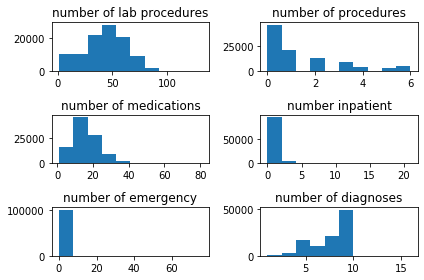

In [99]:
figure, axes = plt.subplots(nrows=3, ncols=2)

axes[0, 0].hist(num_lab_procedures_list)
axes[0, 0].set_title('number of lab procedures')

axes[0, 1].hist(num_procedures_list)
axes[0, 1].set_title('number of procedures')

axes[1, 0].hist(num_medications_list)
axes[1, 0].set_title('number of medications')

axes[1, 1].hist(number_inpatient_list)
axes[1, 1].set_title('number inpatient')

axes[2, 0].hist(number_emergency_list)
axes[2, 0].set_title('number of emergency')

axes[2, 1].hist(number_diagnoses_list)
axes[2, 1].set_title('number of diagnoses')

figure.tight_layout()
display()

### Writing the final cleaned dataframe to CSV

In [109]:
hosp_readmit_cleaned_df.toPandas().to_csv('hospital_readmission_cleaned.csv', index = False)

## END OF DATA CLEANING